In [3]:
import os
import csv
import pandas as pd
import numpy as np
import glob
runsDir = "/Users/giovanni/uni/se22/experiment2/"
qualityEvalFilePrefix = "eval-51quality-"
relevanceEvalFilePrefix = "eval-51relevance-"
# Run file format:
# <measure_name>{spaces}\t<topics>\t<><measure>

Parse run files in runs directory and aggregate them into two files to disk.

In [43]:
# Get quality file
# Get run ids
# Get 
somelist = list()
for filename in glob.glob(runsDir+qualityEvalFilePrefix+"*.txt"):
    names=["measure_name","topic","measure"]
    otherlist = list()
    with open(filename, 'r') as runF:
        findPrefixIndexStart = filename.find(qualityEvalFilePrefix)
        prefixLen = len(qualityEvalFilePrefix)
        runid = filename[findPrefixIndexStart+prefixLen:-4]
        readfile = csv.reader(runF, delimiter='\t')
        for line in readfile:
            meas_name = str(line[0]).replace(" ","").replace("\s","")
            top = str(line[1]).replace(" ","").replace("\s","")
            meas = str(line[2]).replace(" ","").replace("\s","")
            obj = {"runid":runid,"measure_name":meas_name,"topic":top,"measure":meas}
            somelist.append(obj)
df = pd.DataFrame(somelist)
df.to_csv(open("/Users/giovanni/uni/se22/data/quality-runs-eval.csv",'x'))
print(df.columns)
print(df.shape)

somelist = list()
for filename in glob.glob(runsDir+relevanceEvalFilePrefix+"*.txt"):
    names=["measure_name","topic","measure"]
    otherlist = list()
    with open(filename, 'r') as runF:
        findPrefixIndexStart = filename.find(relevanceEvalFilePrefix)
        prefixLen = len(relevanceEvalFilePrefix)
        runid = filename[findPrefixIndexStart+prefixLen:-4]
        readfile = csv.reader(runF, delimiter='\t')
        for line in readfile:
            meas_name = str(line[0]).replace(" ","").replace("\s","")
            top = str(line[1]).replace(" ","").replace("\s","")
            meas = str(line[2]).replace(" ","").replace("\s","")
            obj = {"runid":runid,"measure_name":meas_name,"topic":top,"measure":meas}
            somelist.append(obj)
df = pd.DataFrame(somelist)
df.to_csv(open("/Users/giovanni/uni/se22/data/relevance-runs-eval.csv",'x'))
    # df = pd.read_csv(filename,delimiter="\t",names=["measure_name","topic","measure"],dtype={"measure_name":str,"topic":str,"measure":str})
    # df["measure_name"] = df.apply(lambda row: str(row["measure_name"]).replace("\s", ""), axis=1)
    # print(df.columns)
    # print(df.loc[ df["measure_name"].str.replace("\t","").replace(" ","") == str("runid"),:])


Index(['runid', 'measure_name', 'topic', 'measure'], dtype='object')
(106812, 4)


Build sheets with measures from runs files

In [ ]:
# LIST OF TREC MEASURES TO FIND
interp_prec_at_rec_names = list(["iprec_at_recall_0.00","iprec_at_recall_0.10","iprec_at_recall_0.20","iprec_at_recall_0.30","iprec_at_recall_0.40","iprec_at_recall_0.50","iprec_at_recall_0.60","iprec_at_recall_0.70","iprec_at_recall_0.80","iprec_at_recall_0.90","iprec_at_recall_1.00"])
ndcgs_names = ["ndcg", "ndcg_cut_5"]
avgprec_names = ["map"]
# PATHS
relevanceRunsPath = "/Users/giovanni/uni/se22/data/relevance-runs-eval.csv"
qualityRunsPath = "/Users/giovanni/uni/se22/data/quality-runs-eval.csv"

In [64]:
### READ RELEVANCE DATA FROM DISK
df = pd.read_csv("/Users/giovanni/uni/se22/data/relevance-runs-eval.csv")
### QUERYING DATA FROM DATAFRAME
# SELECT runid,measure_name,measure 
# FROM *
# WHERE topic= all & measure_name in interp_prec_at_rec_names

set_ap_rows = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(["set_P"]))),["runid","measure"]].rename({"measure":"set_P"},axis='columns').set_index("runid")
ndcg_cut5_rows = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(["ndcg_cut_5"]))),["runid","measure"]].rename({"measure":"nDCG@5"},axis='columns').set_index("runid")
set_recall_rows = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(["set_recall"]))),["runid","measure"]].rename({"measure":"set_recall"},axis='columns').set_index("runid")
set_F_rows = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(["set_F"]))),["runid","measure"]].rename({"measure":"set_F"},axis='columns').set_index("runid")

meas_frame = pd.DataFrame()
meas_frame["runid"] = set_ap_rows.index
meas_frame = meas_frame.set_index("runid")
meas_frame = meas_frame.join([set_ap_rows,ndcg_cut5_rows,set_recall_rows,set_F_rows])

meas_frame.to_excel("/Users/giovanni/uni/se22/relevanceOnlyMeasures.xlsx")
with open("/Users/giovanni/uni/se22/relevanceOnlyMeasures.txt",'x') as file:
    file.write(meas_frame.to_latex())

meas_frame["similarity"] = meas_frame.index  
meas_frame["stopwords filter"] = str() 
meas_frame["length filter"] = str() 
meas_frame["english possessive filter"] = str() 
meas_frame["stemmer"] = str() 

meas_frame.loc[ meas_frame.similarity.str.find("lmdir") > -1,"similarity"] = "LMDir"
meas_frame.loc[ meas_frame.similarity.str.find("bm25")> -1,"similarity"] = "BM25"
meas_frame.loc[ meas_frame.similarity.str.find("multi")> -1,"similarity"] = "Multi"
meas_frame.loc[ meas_frame.index.str.find("porter") > -1,"stemmer"] = "Porter"
meas_frame.loc[ meas_frame.index.str.find("kstem") > -1,"stemmer"] = "KStem"
meas_frame.loc[ meas_frame.index.str.find("stop") > -1,"stopwords filter"] = "O"
meas_frame.loc[ meas_frame.index.str.find("len") > -1,"length filter"] = "O"
meas_frame.loc[ meas_frame.index.str.find("engp") > -1,"english possessive filter"] = "O"

meas_frame.to_excel("/Users/giovanni/uni/se22/relevanceConfPlusMeasures.xlsx")
with open("/Users/giovanni/uni/se22/relevanceConfPlusMeasures.txt",'x') as file:
    file.write(meas_frame.to_latex())

meas_fram = meas_frame.sort_values(by="set_F",ascending=False)
meas_frame.to_csv("/Users/giovanni/uni/se22/relevanceConfPlusMeasures.csv")


/var/folders/m4/xy1ccgjx01l6zksfpb1nvbf00000gn/T/ipykernel_52171/1360500903.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  meas_frame.to_latex(buf=file)
/var/folders/m4/xy1ccgjx01l6zksfpb1nvbf00000gn/T/ipykernel_52171/1360500903.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  meas_frame.to_latex(buf=file)


In [66]:
### READ RELEVANCE DATA FROM DISK
df = pd.read_csv("/Users/giovanni/uni/se22/data/quality-runs-eval.csv")
### QUERYING DATA FROM DATAFRAME
# SELECT runid,measure_name,measure 
# FROM *
# WHERE topic= all & measure_name in interp_prec_at_rec_names

set_ap_rows = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(["set_P"]))),["runid","measure"]].rename({"measure":"set_P"},axis='columns').set_index("runid")
ndcg_cut5_rows = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(["ndcg_cut_5"]))),["runid","measure"]].rename({"measure":"nDCG@5"},axis='columns').set_index("runid")
set_recall_rows = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(["set_recall"]))),["runid","measure"]].rename({"measure":"set_recall"},axis='columns').set_index("runid")
set_F_rows = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(["set_F"]))),["runid","measure"]].rename({"measure":"set_F"},axis='columns').set_index("runid")

meas_frame = pd.DataFrame()
meas_frame["runid"] = set_ap_rows.index
meas_frame = meas_frame.set_index("runid")
meas_frame = meas_frame.join([set_ap_rows,ndcg_cut5_rows,set_recall_rows,set_F_rows])

meas_frame.to_excel("/Users/giovanni/uni/se22/qualityOnlyMeasures.xlsx")
with open("/Users/giovanni/uni/se22/qualityOnlyMeasures.txt",'x') as file:
    file.write(meas_frame.to_latex())

meas_frame["similarity"] = meas_frame.index  
meas_frame["stopwords filter"] = str() 
meas_frame["length filter"] = str() 
meas_frame["english possessive filter"] = str() 
meas_frame["stemmer"] = str() 

meas_frame.loc[ meas_frame.similarity.str.find("lmdir") > -1,"similarity"] = "LMDir"
meas_frame.loc[ meas_frame.similarity.str.find("bm25")> -1,"similarity"] = "BM25"
meas_frame.loc[ meas_frame.similarity.str.find("multi")> -1,"similarity"] = "Multi"
meas_frame.loc[ meas_frame.index.str.find("porter") > -1,"stemmer"] = "Porter"
meas_frame.loc[ meas_frame.index.str.find("kstem") > -1,"stemmer"] = "KStem"
meas_frame.loc[ meas_frame.index.str.find("stop") > -1,"stopwords filter"] = "O"
meas_frame.loc[ meas_frame.index.str.find("len") > -1,"length filter"] = "O"
meas_frame.loc[ meas_frame.index.str.find("engp") > -1,"english possessive filter"] = "O"

meas_frame.to_excel("/Users/giovanni/uni/se22/qualityConfPlusMeasures.xlsx")
with open("/Users/giovanni/uni/se22/qualityConfPlusMeasures.txt",'x') as file:
    file.write(meas_frame.to_latex())

meas_fram = meas_frame.sort_values(by="set_F",ascending=False)
meas_frame.to_csv("/Users/giovanni/uni/se22/qualityConfPlusMeasures.csv")


/var/folders/m4/xy1ccgjx01l6zksfpb1nvbf00000gn/T/ipykernel_52171/2592016284.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  file.write(meas_frame.to_latex())
/var/folders/m4/xy1ccgjx01l6zksfpb1nvbf00000gn/T/ipykernel_52171/2592016284.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  file.write(meas_frame.to_latex())


In [56]:
coi_iprec = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(interp_prec_at_rec_names))),["runid","measure_name","measure"]]
coi_ndcgs = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(ndcgs_names))),["runid","measure_name","measure"]]
coi_ap = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(avgprec_names))),["runid","measure_name","measure"]]

coi_ap_ndcg = pd.DataFrame()
coi_ap_ndcg["run"] = coi_ap.loc[:,"runid"]
coi_ap = coi_ap.rename({"measure":"ap"},axis='columns')
coi_ap = coi_ap.drop("measure_name", axis=1).set_index("runid")
coi_ndcgs = coi_ndcgs.loc[(coi_ndcgs["measure_name"]=="ndcg_cut_5") ,:]
coi_ndcgs = coi_ndcgs.rename({"measure":"nDCG@5"},axis='columns').drop("measure_name",axis=1).set_index("runid")
coi_ap_ndcg = coi_ndcgs.join(coi_ap, on="runid")

coi_ap_ndcg["similarity"] = coi_ap_ndcg.index  
coi_ap_ndcg["stopwords filter"] = str() 
coi_ap_ndcg["length filter"] = str() 
coi_ap_ndcg["english possessive filter"] = str() 
coi_ap_ndcg["stemmer"] = str() 

coi_ap_ndcg.loc[ coi_ap_ndcg.similarity.str.find("lmdir") > -1,"similarity"] = "LMDir"
coi_ap_ndcg.loc[ coi_ap_ndcg.similarity.str.find("bm25")> -1,"similarity"] = "BM25"
coi_ap_ndcg.loc[ coi_ap_ndcg.similarity.str.find("multi")> -1,"similarity"] = "Multi"
coi_ap_ndcg.loc[ coi_ap_ndcg.index.str.find("porter") > -1,"stemmer"] = "Porter"
coi_ap_ndcg.loc[ coi_ap_ndcg.index.str.find("kstem") > -1,"stemmer"] = "KStem"
coi_ap_ndcg.loc[ coi_ap_ndcg.index.str.find("stop") > -1,"stopwords filter"] = "O"
coi_ap_ndcg.loc[ coi_ap_ndcg.index.str.find("len") > -1,"length filter"] = "O"
coi_ap_ndcg.loc[ coi_ap_ndcg.index.str.find("engp") > -1,"english possessive filter"] = "O"

set_P  nDCG@5 set_recall   set_F
runid                                                                 
kstemstopengpos-lmdir-YYY-gamora     0.3424  0.6439     0.5076  0.3819
porterstop-multi-YYY-gamora          0.3704  0.6542     0.5502  0.4152
stoplen-bm25-YYY-gamora              0.3248  0.5911     0.4894  0.3649
stopengpos-lmdir-YYY-gamora          0.3380  0.6146     0.4983  0.3751
stopengpos-bm25-YYY-gamora           0.3344  0.5903     0.5004  0.3751
porterstop-bm25-YYY-gamora           0.3368  0.5699     0.5077  0.3804
kstemstop-lmdir-YYY-gamora           0.3420  0.6446     0.5072  0.3815
kstemstopengpos-bm25-YYY-gamora      0.3400  0.5898     0.5136  0.3832
kstemstoplen-lmdir-YYY-gamora        0.3384  0.6406     0.5004  0.3771
kstemstoplen-bm25-YYY-gamora         0.3376  0.5925     0.5108  0.3806
stop-multi-YYY-gamora                0.3604  0.6403     0.5294  0.4009
stop-bm25-YYY-gamora                 0.3344  0.5877     0.5006  0.3752
kstemlenstopengpos-bm25-YYY-gamora   0.3396  0.5900     0.5130  0.3827
stoplen-lmdir-YYY-gamora             0.3364  0.6123     0.4909  0.3724
porterstop-lmdir-YYY-gamora          0.3400  0.6105     0.4960  0.3782
kstemstopengpos-multi-YYY-gamora     0.3656  0.6737     0.5426  0.4094
kstemstop-bm25-YYY-gamora            0.3396  0.5864     0.5130  0.3827
stopengpos-multi-YYY-gamora          0.3580  0.6444     0.5257  0.3982
kstemlenstopengpos-multi-YYY-gamora  0.3624  0.6744     0.5397  0.4065
kstemstop-multi-YYY-gamora           0.3648  0.6733     0.5421  0.4087
stop-lmdir-YYY-gamora                0.3384  0.6146     0.4995  0.3758
kstemstoplen-multi-YYY-gamora        0.3620  0.6702     0.5394  0.4061
stoplen-multi-YYY-gamora             0.3572  0.6398     0.5234  0.3969

In [52]:
coi_ap_ndcg.to_excel("relevance.xlsx")

Plotting iprec at ndcg

In [68]:
import matplotlib as plt
coi_iprec = df.loc[( (df["topic"].astype(str)=="all") & (df["measure_name"].isin(interp_prec_at_rec_names))),["runid","measure_name","measure"]]
average_prec_over_all_topics_calc = df.loc[( (df["topic"].astype(str)!="all") & (df["measure_name"].isin(["set_P"]))),["runid","topic","measure"]]
prec_diff_per_topic = pd.DataFrame()
prec_diff_per_topic = average_prec_over_all_topics_calc.loc[:,["runid","topic"]].drop_duplicates()
prec_diff_per_topic.shape

(1150, 2)

In [75]:
lli = list()

In [76]:
for runid,topic in prec_diff_per_topic.values:
    avg = average_prec_over_all_topics_calc.loc[((average_prec_over_all_topics_calc.runid == str(runid))&(average_prec_over_all_topics_calc.topic == str(topic))),"measure"].mean()
    runAvg =  set_ap_rows.loc[(set_ap_rows.index == runid),"set_P"]
    diff = float(avg)-float(runAvg)
    lli.append({"runid":runid,"topic":topic,"diff":diff})

In [77]:
avg_per_topic_prec_diff = pd.DataFrame(lli)

In [79]:
best_runs = ["kstemstopengpos-multi-YYY-gamora","kstemstopengpos-bm25-YYY-gamora","kstemstopengpos-lmdir-YYY-gamora"]

In [118]:
dati_best = coi_iprec.loc[coi_iprec.runid.isin(best_runs),["runid","measure_name","measure"]]
x = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


In [122]:
y_list = list()
for idd in best_runs:
    rows = dati_best.loc[dati_best.runid==idd,["measure_name","measure"]]
    y = [None]*11
    for name,meas in rows.values:
        if name.find("0.0") > -1:
            y[0] = meas
        if name.find("0.1") > -1:
            y[1] = meas
        if name.find("0.2") > -1:
            y[2] = meas
        if name.find("0.3") > -1:
            y[3] = meas
        if name.find("0.4") > -1:
            y[4] = meas
        if name.find("0.5") > -1:
            y[5] = meas
        if name.find("0.6") > -1:
            y[6] = meas
        if name.find("0.7") > -1:
            y[7] = meas
        if name.find("0.8") > -1:
            y[8] = meas
        if name.find("0.9") > -1:
            y[9] = meas
        if name.find("1.0") > -1:
            y[10] = meas
    y_list.append({"runid":idd,"y":y})

In [123]:
dddf = pd.DataFrame(y_list)
display(y_list)

[{'runid': 'kstemstopengpos-multi-YYY-gamora',
  'y': ['0.9971',
   '0.9338',
   '0.7963',
   '0.6061',
   '0.2962',
   '0.1112',
   '0.0164',
   '0.0164',
   '0.0000',
   '0.0000',
   '0.0000']},
 {'runid': 'kstemstopengpos-bm25-YYY-gamora',
  'y': ['0.9831',
   '0.8072',
   '0.6342',
   '0.4286',
   '0.2395',
   '0.0961',
   '0.0154',
   '0.0149',
   '0.0000',
   '0.0000',
   '0.0000']},
 {'runid': 'kstemstopengpos-lmdir-YYY-gamora',
  'y': ['0.9967',
   '0.9348',
   '0.7753',
   '0.5994',
   '0.2580',
   '0.0614',
   '0.0247',
   '0.0000',
   '0.0000',
   '0.0000',
   '0.0000']}]

In [175]:
dddf.to_csv("/Users/giovanni/uni/se22/ipatrec.csv")

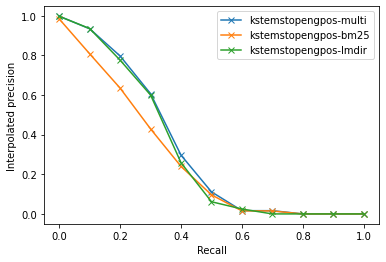

<Figure size 432x288 with 0 Axes>

In [174]:
import matplotlib.pyplot  as plt
for runidd in best_runs:
    y_data = dddf.loc[dddf.runid==runidd,"y"].values[0]
    yy = [float(y) for y in y_data]
    plt.plot(x,yy, '-x',label=runidd.replace("-YYY-gamora",""))
plt.ylabel("Interpolated precision")
plt.xlabel("Recall")
plt.legend()
plt.show()
plt.savefig("/Users/giovanni/uni/se22/ipatrec.png",dpi=400)
